In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

{'cpu': 125.15761604309083, 'gpu': 69.19827160835266}


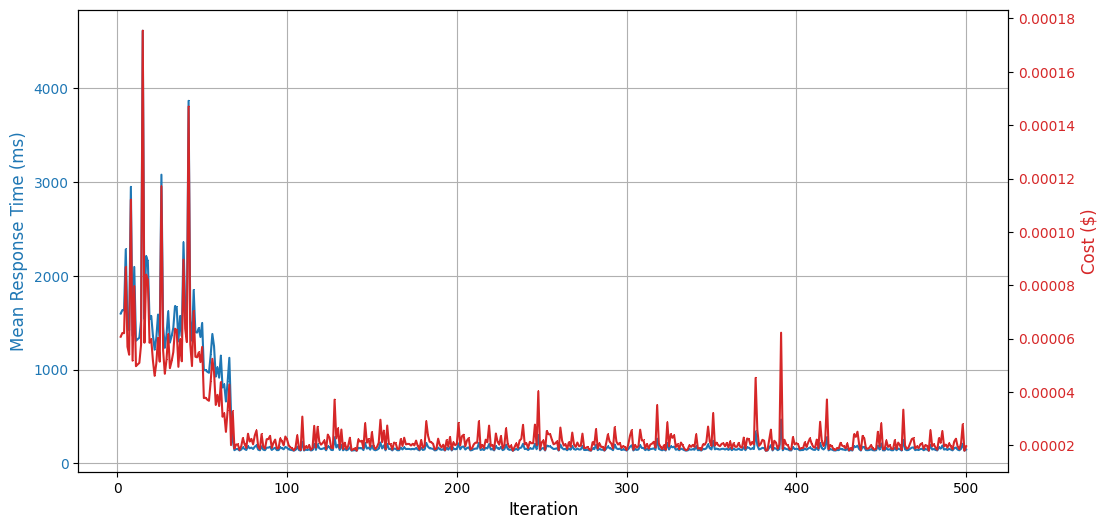

In [2]:
csv_files_auto = glob.glob("./data/auto/*response_times.csv")

dfs_auto = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_auto]

combined_auto = pd.concat(dfs_auto, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

combined_auto.head()

row_means = pd.DataFrame({
    "iteration": range(1, len(combined_auto) + 1),
    "mean_response_time": combined_auto.mean(axis=1).values
})

row_means["response_time_s"] = row_means["mean_response_time"] / 1000

# determine execution type
row_means["execution_type"] = row_means["response_time_s"].apply(
    lambda x: "cpu" if x > 0.5 else "gpu"
)

auto_run_times = row_means.groupby("execution_type")["response_time_s"].sum().to_dict()
print(auto_run_times)

# remove first row (cold start) for better visualization
row_means = row_means.iloc[1:]

# assign rates
cpu_rate = 0.000038  # per second
gpu_rate = 0.000133  # per second

# calculate cost per mean response time for this plot
row_means["cost"] = row_means.apply(
    lambda row: row["response_time_s"] * (cpu_rate if row["execution_type"] == "cpu" else gpu_rate),
    axis=1
)

# plot with iteration on x axis and mean_response_time on y axis
# First y-axis: response time
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(row_means["iteration"], row_means["mean_response_time"], color="tab:blue", marker=',')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Mean Response Time (ms)", fontsize=12, color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Second y-axis: cost
ax2 = ax1.twinx()
ax2.plot(row_means["iteration"], row_means["cost"], color="tab:red", marker=',')
ax2.set_ylabel("Cost ($)", fontsize=12, color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.show()


In [15]:
# Export to csv

df_lines = pd.DataFrame({
    "response_time": row_means["mean_response_time"],
    "cost": row_means["cost"]
})

# Save to CSV
df_lines.to_csv("response_time_chart.csv", index_label="Index")

In [3]:
# Auto Cost Calculation
results = []

for df in dfs_auto:
    df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000
    df["gpu_used"] = df["response_time_s"] <= 0.5

    grouped = df.groupby("gpu_used")["response_time_s"].sum()
    results.append(grouped)

seconds_per_execution_mode_per_run_auto = pd.DataFrame(results).fillna(0)

seconds_per_execution_mode_per_run_auto += 30

cost_per_execution_mode_per_run_auto = pd.DataFrame({
    False: seconds_per_execution_mode_per_run_auto[False] * cpu_rate,
    True: seconds_per_execution_mode_per_run_auto[True] * gpu_rate,
})

mean_cost_per_execution_mode_auto = cost_per_execution_mode_per_run_auto.mean()

cost_auto = mean_cost_per_execution_mode_auto.sum()

print(seconds_per_execution_mode_per_run_auto)
print(cost_per_execution_mode_per_run_auto)
print(mean_cost_per_execution_mode_auto)
print(cost_auto)


gpu_used              False       True 
response_time_s  163.350035  100.332893
response_time_s  152.734646   99.027140
response_time_s  163.145784   98.705829
response_time_s  152.744489   99.255731
response_time_s  143.501054   98.981837
                    False     True 
response_time_s  0.006207  0.013344
response_time_s  0.005804  0.013171
response_time_s  0.006200  0.013128
response_time_s  0.005804  0.013201
response_time_s  0.005453  0.013165
False    0.005894
True     0.013202
dtype: float64
0.019095288902282716


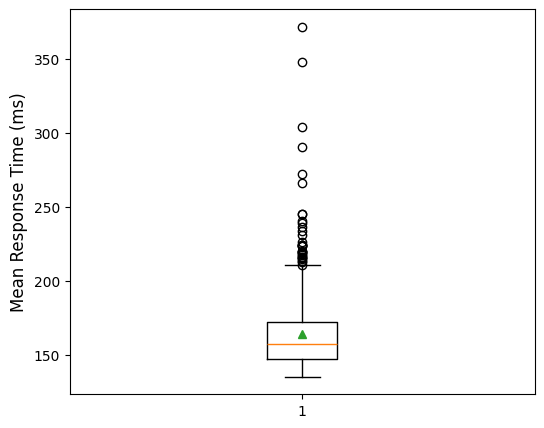

In [4]:
# GPU Boxplot
csv_files_gpu = glob.glob("./data/gpu/*response_times.csv")

dfs_gpu = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_gpu]

combined_gpu = pd.concat(dfs_gpu, axis=1)
combined_gpu.columns = [f"run_{i + 1}" for i in range(len(dfs_gpu))]

response_time_sum_gpu = combined_gpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_gpu = combined_gpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_gpu, showmeans=True)

# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

In [5]:
# GPU Cost Calculation

results = []

for df in dfs_gpu:
    df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_gpu = pd.DataFrame(results).fillna(0)
seconds_gpu += 30

cost_per_run_gpu = seconds_gpu * gpu_rate
mean_cost_gpu = cost_per_run_gpu.mean()

cost_gpu = mean_cost_gpu.sum()

print(cost_gpu)

0.019138644045114516


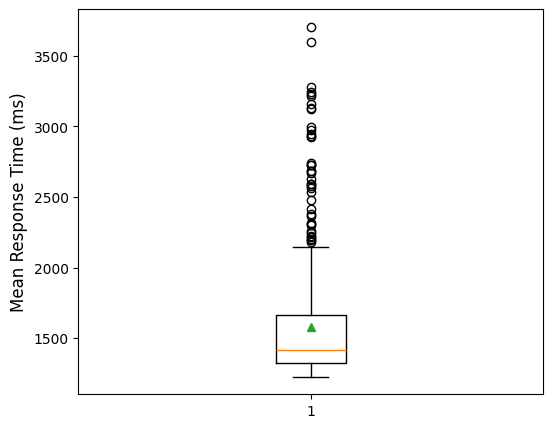

In [6]:
# CPU Boxplot
csv_files_cpu = glob.glob("./data/cpu/*response_times.csv")

dfs_cpu = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_cpu]

combined_cpu = pd.concat(dfs_cpu, axis=1)
combined_cpu.columns = [f"run_{i + 1}" for i in range(len(dfs_cpu))]

combined_cpu.head()

response_time_sum_cpu = combined_cpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_cpu = combined_cpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_cpu, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()


In [7]:
# CPU Cost Calculation

results = []

for df in dfs_cpu:
    df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_cpu = pd.DataFrame(results).fillna(0)
seconds_cpu += 30

cost_per_run_cpu = seconds_cpu * cpu_rate
mean_cost_cpu = cost_per_run_cpu.mean()

cost_cpu = mean_cost_cpu.sum()

print(cost_cpu)

0.03205865064888001


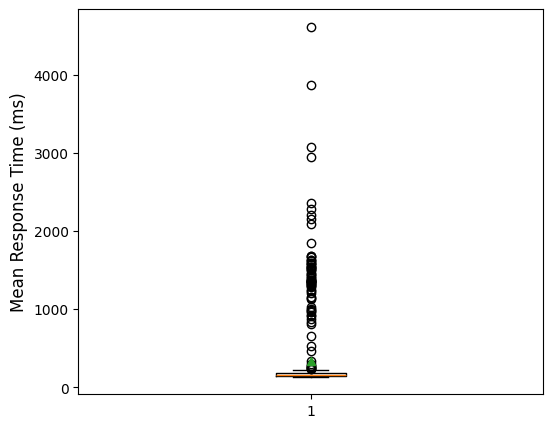

In [8]:
# Auto Boxplot
combined_auto = pd.concat(dfs_auto, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

combined_auto.head()


# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_auto = combined_auto.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_auto, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

[np.float64(0.03205865064888001), np.float64(0.019138644045114516), np.float64(0.019095288902282716)]


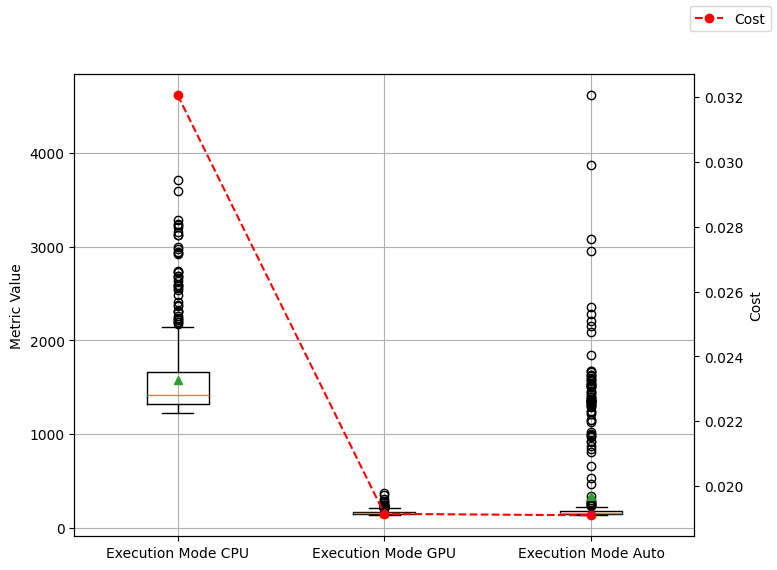

In [9]:
# Combine both CPU and GPU data for comparison

data = [row_means_without_coldstart_cpu, row_means_without_coldstart_gpu, row_means_without_coldstart_auto]

fig, ax1 = plt.subplots(figsize=(8,6))

# Boxplots on left y-axis
ax1.boxplot(
    data,
    tick_labels=["Execution Mode CPU", "Execution Mode GPU", "Execution Mode Auto"],
    showmeans=True
)
ax1.set_ylabel("Metric Value")

costs = [cost_cpu, cost_gpu, cost_auto]

print(costs)

positions = [1, 2, 3]


# Add a second axis for costs
ax2 = ax1.twinx()
# positions = [1, 2, 3]
ax2.plot(positions, costs, "ro--", label="Cost")  # red dotted line with markers
ax2.set_ylabel("Cost")

ax1.grid(True)
fig.legend()
plt.show()


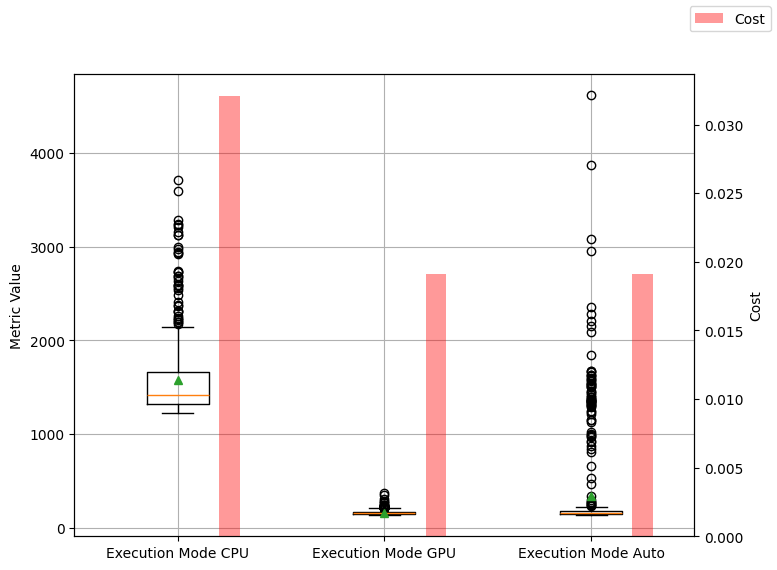

In [10]:
fig, ax1 = plt.subplots(figsize=(8,6))

positions = [1, 2, 3]
ax1.boxplot(
    data,
    tick_labels=["Execution Mode CPU", "Execution Mode GPU", "Execution Mode Auto"],
    showmeans=True,
    positions=positions
)
ax1.set_ylabel("Metric Value")

# Second axis for costs
ax2 = ax1.twinx()

# Shifted & thinner bars
bar_width = 0.1
offset = 0.25  # shift to the right
ax2.bar(
    [p + offset for p in positions],
    costs,
    width=bar_width,
    color="red",
    alpha=0.4,
    label="Cost"
)

ax2.set_ylabel("Cost")
ax1.grid(True)
fig.legend()
plt.show()

In [13]:
# Export to CSV
rows = []
modes = ["CPU", "GPU", "Auto"]

for mode, values in zip(modes, data):
    for v in values:
        rows.append({"Execution Mode": mode, "Response Time": v})

df_boxplot = pd.DataFrame(rows)
df_costs = pd.DataFrame({
    "Execution Mode": modes,
    "Cost": costs
})

# Save
df_boxplot.to_csv("boxplot_data.csv", index=False)
df_costs.to_csv("costs.csv", index=False)



In [12]:
# Calculate and print summary statistics

# mean of first values
auto_coldstart = combined_auto.iloc[0].mean()
gpu_coldstart = combined_gpu.iloc[0].mean()
cpu_coldstart = combined_cpu.iloc[0].mean()


print(f"Auto Cold Start Mean: {auto_coldstart:.2f} ms")
print(f"GPU Cold Start Mean: {gpu_coldstart:.2f} ms")
print(f"CPU Cold Start Mean: {cpu_coldstart:.2f} ms")

Auto Cold Start Mean: 24471.46 ms
GPU Cold Start Mean: 31869.98 ms
CPU Cold Start Mean: 26523.70 ms
